# OFFLINE DIGIT RECOGNITION

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import idx2numpy
import math as m
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2 as cv

# KNN Class

In [2]:
class k_nearest_neighbour:
    def __init__(self,K):
        self.K=K
    
    def fit(self,data,labels):
        self.data=data
        self.label=labels
    
    def euclidean_distance(self,row2,row1):
        return np.linalg.norm(row1-row2)
    
    def get_neighbors(self,data,label,test_row):
        dist=[]
        for i in range(data.shape[0]):
            dist.append([data[i],label[i],self.euclidean_distance(test_row,data[i])])
        dist.sort(key = lambda x : x[2])
        neighbours=[]
        neighbours=np.array(dist[:self.K],dtype = object)
        return neighbours
        
    def predict_classification(self,neighbours):   
        a = []
        for i in neighbours:
            a.append(i[1])
        prediction=max(set(a),key = a.count)
        return prediction
                
    def predict(self,data_test):
        pred_label=np.zeros(data_test.shape[0])
        for i in range(data_test.shape[0]):
            neig=self.get_neighbors(self.data,self.label, data_test[i,:])
            pred_label[i]=self.predict_classification(neig)
        return pred_label

    def accuracy(self,test_label,pred_label):        
        
        count=0
        for i in range(len(pred_label)):
            if(int(test_label[i])==int(pred_label[i])):
                count+=1
        return count/len(pred_label)

# Naive Bayes Class

In [3]:
class NaiveBayes:
    def __init__(self):
        return
    def class_dictionary(self,data,labels):
        class_dict={}
        unique=np.unique(labels)
        for i in unique:
            class_dict[int(i)]=data[np.where(labels==i)]
        return class_dict
    
    def get_variables(self,class_dict):
        var_dict = {}
        for i in class_dict:
            a=np.array(class_dict[i])
            l,s=a.shape
            M=[np.mean(a[:,k]) for k in range(s)]
            SD=np.sqrt([sum([(k[j]-M[j])**2 for k in a])/l for j in range(s)])
            var_dict[int(i)]=[(M[k],SD[k],l) for k in range(s)]
        return var_dict
    
    def calculate_probability(self,x,mean,stdev):
        if stdev == 0.0:
            if x==mean:
                return 1
            else:
                return 10**(-300)
        else:
            exponent = m.exp(-((x-mean)**2 / (2 * stdev**2 )))
            a = 1 / (m.sqrt(2 * m.pi) * stdev) * exponent
            if a==0.0:
                return 10**(-300)
            else:
                return a
    
    def calculate_class_probabilities(self,summaries,row):
        probabilities = {}
        pts=sum([i[0][2] for i in summaries.values()])
        for class_label,class_params in summaries.items():
            probabilities[class_label] = m.log(summaries[class_label][0][2]/pts)
            for i in range(len(class_params)):
                mu,s,l = class_params[i]
                probabilities[class_label] += m.log(self.calculate_probability(row[i],mu,s))
        return probabilities
    
    def fit(self,data,labels):
        self.data=data
        self.labels=labels
        self.class_dict = self.class_dictionary(self.data,self.labels)
        self.var_dict = self.get_variables(self.class_dict)
        self.mean_vectors=[]
        for i in self.var_dict:
            a=[]
            for j in self.var_dict[i]:
                a.append(j[0])
            self.mean_vectors.append(a)
        self.mean_vectors=np.array(self.mean_vectors)
        self.n_classes = len(set(labels))
            

    def predict(self,data):
        self.l_pred=[]
        self.log_prob_pred=[]
        for i in data:
            p=self.calculate_class_probabilities(self.var_dict,i)
            self.log_prob_pred.append(p)
            self.l_pred.append(max(p,key=lambda x:p[x]))
        return self.l_pred
    
    def accuracy(self,y_tr,y_pred):
        s=0
        for i in range(len(y_tr)):
            if int(y_tr[i])==y_pred[i]:
                s+=1
        return s/len(y_tr)


# Logistic Regression Class

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Logistic_Regression():

    def __init__(self, lr=0.001, n_iters=1000,func="sigmoid",eps=10**(-7)):
        if func.lower()=="sigmoid" or func.lower()=="tanh":
            self.func=func.lower()
        else:
            raise AttributeError("Invalid logistic function.Valid functions are 'Sigmoid' and 'Tanh'")
        self.lr = lr
        self.n_iters = n_iters
        self.eps=eps
        
    def Error(self,pred,y):
        return -1*np.mean(y*np.log(pred+10**(-30))+(1-y)*np.log(1-pred+10**(-30)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(X.shape[1])
        self.data=X
        self.X=np.concatenate((X.T,np.ones((1,X.shape[0])))).T
        self.error=[100]
        self.converged=False

        for i in range(self.n_iters):
            linear_pred = np.dot(X, self.weights)
            if self.func=="sigmoid":
                predictions = sigmoid(linear_pred)
            elif self.func=="tanh":
                predictions = (1+np.tanh(linear_pred))/2
            self.error.append(self.Error(predictions,y))
            self.weights = self.weights - self.lr*((1/X.shape[0]) * np.dot(X.T, (predictions - y)))
            if self.error[-1]<=self.eps:
                self.converged=True
                break
        self.error.pop(0)
    def predict(self, X):
        linear_pred = np.dot(X, self.weights)
        if self.func=="sigmoid":
            y_pred = sigmoid(linear_pred)
        elif self.func=="tanh":
            y_pred = (1+np.tanh(linear_pred))/2
        self.class_pred = [0 if y<0.5 else 1 for y in y_pred]
        return self.class_pred
    
    def accuracy(self, y_pred, y_test):
        return np.sum(y_pred==y_test)/len(y_test)

# Support Vector Machine Class

In [5]:
class SupportVectorMachine:
    def __init__(self,lr=0.01,n_iter=1000,Lambda=1):
        self.lr=lr
        self.n_iter=n_iter
        self.Lambda=Lambda
    
    def update_weights(self):
        for i,x_i in enumerate(self.X):
            y_i=self.y[i]
            if y_i*(np.dot(x_i,self.w)-self.b)>=1:
                self.w = self.w - 2 * self.lr * self.Lambda * self.w
            else:
                self.w = self.w - self.lr * (2 * self.Lambda * self.w - x_i * y_i)
                self.b = self.b - self.lr * y_i
    def fit(self,X,y):
        self.X=X
        a=y.copy()
        for i in range(len(a)):
            if a[i]<=0:
                a[i]=-1
            else:
                a[i]=1
        self.y=a
        self.n_fv,self.n_f = X.shape
        self.w=np.zeros(self.n_f)
        self.b=0
        for i in range(self.n_iter):
            self.update_weights()
            
    def predict(self,X):
        self.X_t=X
        pred_lab=np.sign(np.dot(self.X_t,self.w) - self.b)
        for i in range(len(pred_lab)):
            if pred_lab[i] == -1:
                pred_lab[i]=0
        self.pred_lab=pred_lab
        return pred_lab
    
    def accuracy(self,tr_lab,pr_lab):
        s=0
        l=len(tr_lab)
        for i,j in zip(tr_lab,pr_lab):
            if int(i)==int(j):
                s+=1
        return s/l
    
    def accuracy(self,tr_lab):
        s=0
        l=len(tr_lab)
        for i,j in zip(tr_lab,self.pred_lab):
            if int(i)==int(j):
                s+=1
        return s/l

# Decision Tree Class

In [6]:
class node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,value=None):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value
    
    def is_leaf_node(self):
        return self.value is not None

class Decision_Tree:
    def __init__(self,min_samples=2,max_depth=100,n_features=None):
        self.min_samples=min_samples
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None
        
    def most_common_lab(self,y):
        buff=np.unique(y)
        y=y.tolist()
        return max(buff,key=y.count)
    
    def entropy(self,y):
        u,c=np.unique(y,return_counts=True)
        prob=c/len(y)
        return np.sum([-1*p*np.log2(p) for p in prob if p>0])
    
    def split(self,X_col,thr):
        left_idx=np.argwhere(X_col<=thr).reshape(-1)
        right_idx=np.argwhere(X_col>thr).reshape(-1)
        return left_idx,right_idx
    
    def find_gain(self,X_col,y,thr):
        p_entropy = self.entropy(y)
        l_idx,r_idx = self.split(X_col,thr)
        l=len(l_idx)
        r=len(r_idx)
        t=len(y)
        if(l==0 or r==0):
            return 0
        else:
            l_entropy = self.entropy(y[l_idx])
            r_entropy = self.entropy(y[r_idx])
            c_entropy = (l*l_entropy+r*r_entropy)/t
            return p_entropy - c_entropy
    
    def find_best_split(self,X,y,f_idx):
        gain=-1
        split_idx=None
        split_threshold=None
        
        for f in f_idx:
            X_col=X[:,f]
            possible_thresholds=np.unique(X_col)
            for t in possible_thresholds:
                g=self.find_gain(X_col,y,t)
                if g>gain:
                    gain=g
                    split_idx=f
                    split_threshold=t
        return split_idx,split_threshold
                
        
    
    def grow_tree(self,X,y,depth=0):
        n_s,n_f=X.shape
        lab=np.unique(y)
        n_lab=len(lab)
        
        if(n_lab==1 or depth>=self.max_depth or n_s<self.min_samples):
            leaf_value=self.most_common_lab(y)
            return node(value=leaf_value)
        if(n_f==self.n_features):
            f_idx=np.arange(n_f)
        else:
            f_idx=np.random.choice(n_f,self.n_features,replace=False)
        
        b_f,b_thr = self.find_best_split(X,y,f_idx)
        
        l_idx,r_idx = self.split(X[:,b_f],b_thr)
        
        left_subtree=self.grow_tree(X[l_idx,:],y[l_idx],depth+1)
        right_subtree=self.grow_tree(X[r_idx,:],y[r_idx],depth+1)
        return node(b_f,b_thr,left_subtree,right_subtree)
        
    def fit(self,X,y):
        self.n_features=X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root=self.grow_tree(X,y)
        
    def make_prediction(self,x,node):
        if node.is_leaf_node():
            return node.value
        
        else:
            if x[node.feature] <= node.threshold:
                return self.make_prediction(x,node.left)
            else:
                return self.make_prediction(x,node.right)
    
    def predict(self,X_test):
        
        y_pred = [self.make_prediction(x,self.root) for x in X_test]
        
        return y_pred

# Random Forest Class

In [7]:
class Random_Forest:
    def __init__(self,n_trees,n_features,min_samples=2,max_depth=10):
        self.min_samples=min_samples
        self.max_depth=max_depth
        self.n_features=n_features
        self.n_trees=n_trees
        self.forest=[]
        
    def fit(self,X,y):
        for i in range(self.n_trees):
            tree = Decision_Tree(min_samples=self.min_samples,max_depth=self.max_depth,n_features=self.n_features)
            boot_idx=np.random.choice(X.shape[0],X.shape[0])
            boot_X=X[boot_idx]
            boot_y=y[boot_idx]
            tree.fit(boot_X,boot_y)
            self.forest.append(tree)
    def predict(self,X_test):
        n_t=X_test.shape[0]
        y=np.array([np.array(self.forest[i].predict(X_test)).reshape(n_t,1) for i in range(self.n_trees)])
        Y=y.T.tolist()
        Y=Y[0]
        y_pred=[max(Y[i],key=Y[i].count) for i in range(n_t)]
        return y_pred

# DATA

In [8]:
img_train_path="mnist_data/train-images-idx3-ubyte"
label_train_path="mnist_data/train-labels-idx1-ubyte"

img_test_path = "mnist_data/t10k-images-idx3-ubyte"
label_test_path = "mnist_data/t10k-labels-idx1-ubyte"

Images_train = idx2numpy.convert_from_file(img_train_path)
Labels_train = idx2numpy.convert_from_file(label_train_path)

Images_test = idx2numpy.convert_from_file(img_test_path)
Labels_test = idx2numpy.convert_from_file(label_test_path)

Images_train=Images_train.reshape((Images_train.shape[0],784))
Images_test=Images_test.reshape((Images_test.shape[0],784))

ma,mi=np.max(Images_train),np.min(Images_train)
Images_train=(Images_train-mi)/(ma-mi)
ma,mi=np.max(Images_test),np.min(Images_test)
Images_test=(Images_test-mi)/(ma-mi)

Images_train=Images_train[:18000]
Labels_train=Labels_train[:18000]
Images_test=Images_test[:2000]
Labels_test=Labels_test[:2000]

In [9]:
data_dict={"KNN":[-1,-1,-1],"NB":[-1,-1,-1],"LR":[-1,-1,-1],"SVM":[-1,-1,-1],"DT":[-1,-1,-1],"RF":[-1,-1,-1]}

# Implementing KNN

In [10]:
def euclidean_distance(row1, row2):
    return np.linalg.norm(row1-row2)

def get_neighbors(train,label_train, test_row, num_neighbors):
    dist=[]
    for i in range(train.shape[0]):
        dist.append([train[i],label_train[i],euclidean_distance(test_row,train[i])])
    dist.sort(key = lambda x : x[2])
    neighbours=[]
    neighbours=np.array(dist[:num_neighbors],dtype = object)
    return neighbours

def predict_classification(neighbours):
    a = []
    for i in neighbours:
        a.append(i[1])
    prediction=max(set(a),key = a.count)
    return prediction
start=time.time()
pts=35
pred_label=np.zeros(Images_test.shape[0])
for i in range(Images_test.shape[0]):
    neig=get_neighbors(Images_train,Labels_train, Images_test[i,:], pts)
    pred_label[i]=predict_classification(neig)
end=time.time()

In [11]:
knn_accuracy=(len(np.where(pred_label == Labels_test)[0])/float(len(Labels_test)))*100
knn_time=t=end-start if end-start>10**(-7) else 0
t=knn_time
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
print(f"Accuracy : {knn_accuracy}%")
data_dict["KNN"][0]=0
data_dict["KNN"][1]=t
data_dict["KNN"][2]=knn_accuracy

Testing time : 0.0h 3.0m 22.29980707168579s
Accuracy : 90.60000000000001%


# Implementing Naive Bayes

In [12]:
start=time.time()
nb=NaiveBayes()
nb.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Traininging time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["NB"][0]=t

Traininging time : 0.0h 0.0m 7.09204626083374s


In [13]:
start=time.time()
nb_pred=nb.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["NB"][1]=t

Testing time : 0.0h 0.0m 20.250720977783203s


In [14]:
nb_accuracy=nb.accuracy(Labels_test,nb_pred)
print(f"Accuracy : {nb_accuracy*100}%")
data_dict["NB"][2]=nb_accuracy*100

Accuracy : 73.55000000000001%


# Implementing Logistic Regression

In [15]:
Images = idx2numpy.convert_from_file('mnist_data/t10k-images-idx3-ubyte')
Labels = idx2numpy.convert_from_file('mnist_data/t10k-labels-idx1-ubyte')

Images=Images.reshape((Images.shape[0],784))

Images_train = Images[:-1000]
Labels_train = Labels[:-1000]

Images_test = Images[-1000:]
Labels_test = Labels[-1000:]

idx_labels_0=np.where(Labels_train==2)
idx_labels_0=idx_labels_0[0]
Im_cl_0=Images_train[idx_labels_0]
Lb_cl_0=Labels_train[idx_labels_0]

idx_labels_1=np.where(Labels_train!=2)
idx_labels_1=idx_labels_1[0]
Im_cl_1=Images_train[idx_labels_1]
Lb_cl_1=Labels_train[idx_labels_1]

d=np.concatenate((Im_cl_0,Im_cl_1))
l=np.concatenate((Lb_cl_0,Lb_cl_1))
l=np.concatenate((np.zeros(Lb_cl_0.shape[0]),np.ones(Lb_cl_1.shape[0])))

lr=Logistic_Regression(func="tanh")
lr.fit(d,l)

d2=Images_test[np.where(Labels_test==2)]
d3=Images_test[np.where(Labels_test!=2)]
test=np.concatenate((d2,d3))
test_l=np.concatenate((np.zeros((d2.shape[0])),np.ones(d3.shape[0])))
pred=lr.predict(test.reshape(test.shape[0],784))
Lreg=(len(np.where(pred==test_l)[0])/len(pred))
print(f"Acccuracy : {Lreg*100}%")

Acccuracy : 95.8%


In [16]:
start=time.time()
models=[]
for i in range(10):
    l = Labels_train.tolist()
    for j in range(len(l)):
        if l[j]==i:
            l[j]=1
        else:
            l[j]=0
    l=np.array(l)
    lr=Logistic_Regression(func="tanh")
    lr.fit(Images_train,l)
    models.append(lr)
end=time.time()

t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["LR"][0]=t

Training time : 0.0h 1.0m 43.37838101387024s


In [17]:
y_pred=[]
start=time.time()
for i in range(10):
    y_pred.append(models[i].predict(Images_test))
Y=np.array(y_pred)
Y=Y.T
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["LR"][1]=t

Testing time : 0.0h 0.0m 0.013818979263305664s


In [18]:
a=-1*np.ones(len(Labels_test))
d={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for i in range(len(Y)):
    k=np.where(Y[i]==1)[0]
    d[len(k)]+=1
    if len(k) == 0:
        a[i]=(np.random.randint(10))
    else:
        a[i]=np.random.choice(k)
print(d)

y_pred=a
acc=len(np.where(y_pred==Labels_test)[0])/len(y_pred)*100
print(f"Accuracy : {acc}%")
data_dict["LR"][2]=acc

{0: 89, 1: 743, 2: 158, 3: 9, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Accuracy : 76.0%


# Implementing SVM

In [19]:
img_train_path="mnist_data/train-images-idx3-ubyte"
label_train_path="mnist_data/train-labels-idx1-ubyte"

img_test_path = "mnist_data/t10k-images-idx3-ubyte"
label_test_path = "mnist_data/t10k-labels-idx1-ubyte"

Images_train = idx2numpy.convert_from_file(img_train_path)
Labels_train = idx2numpy.convert_from_file(label_train_path)

Images_test = idx2numpy.convert_from_file(img_test_path)
Labels_test = idx2numpy.convert_from_file(label_test_path)

Images_train=Images_train.reshape((Images_train.shape[0],784))
Images_test=Images_test.reshape((Images_test.shape[0],784))

ma,mi=np.max(Images_train),np.min(Images_train)
Images_train=(Images_train-mi)/(ma-mi)
ma,mi=np.max(Images_test),np.min(Images_test)
Images_test=(Images_test-mi)/(ma-mi)

Images_train=Images_train[:18000]
Labels_train=Labels_train[:18000]
Images_test=Images_test[:2000]
Labels_test=Labels_test[:2000]

In [20]:
start=time.time()
Lab=[[] for i in range(len(Labels_test))]
models=[[[None] for i in range(10)] for i in range(10)]
for k in range(10):
    for l in [i for i in range(10) if i!=k]:
        i=np.where(Labels_train==k)
        j=np.where(Labels_train==l)

        I_train=np.concatenate((Images_train[i],Images_train[j]))
        L_train=np.concatenate((np.zeros(len(*i)),np.ones(len(*j))))

        i=np.where(Labels_test==k)
        j=np.where(Labels_test==l)

        I_test=np.concatenate((Images_test[i],Images_test[j]))
        L_test=np.concatenate((np.zeros(len(*i)),np.ones(len(*j))))

        svm=SupportVectorMachine(Lambda=0.001,n_iter=2000)
        svm.fit(I_train,L_train)
        models[k][l][0]=svm
        buf=svm.predict(I_test)
        d={0.0:k,1.0:l}
        models[k][l].append(d)
        a=0
        for p in np.concatenate((i[0],j[0])):
            Lab[p].append(d[buf[a]])
            a+=1
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["SVM"][0]=t

Training time : 0.0h 39.0m 48.50213289260864s


In [21]:
start=time.time()
pred_lab=[]
for i in range(len(Lab)):
    k=Lab[i]
    pred_lab.append(max(k,key=k.count))
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["SVM"][1]=t
s=0
for i in range(len(Labels_test)):
    if pred_lab[i]==Labels_test[i]:
        s+=1
acc=(s/len(Labels_test)*100)
print(f"Accuracy : {acc}%")
data_dict["SVM"][2]=acc

Testing time : 0.0h 0.0m 0.005207061767578125s
Accuracy : 100.0%


# Decision Tree

In [22]:
dt=Decision_Tree()
start=time.time()
dt.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["DT"][0]=t

Training time : 0.0h 22.0m 55.021679162979126s


In [23]:
start=time.time()
y_pred=dt.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["DT"][1]=t
acc=len(np.where(y_pred==Labels_test)[0])/len(y_pred)*100
print(f"Accuracy : {acc}%")
data_dict["DT"][2]=acc

Testing time : 0.0h 0.0m 0.013247013092041016s
Accuracy : 80.95%


# Random Forest

In [24]:
start=time.time()
rf=Random_Forest(30,50)
rf.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["RF"][0]=t

Training time : 0.0h 30.0m 39.73367094993591s


In [25]:
start=time.time()
y_pred=rf.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict["RF"][1]=t
acc=len(np.where(y_pred==Labels_test)[0])/len(y_pred)*100
print(f"Accuracy : {acc}%")
data_dict["RF"][2]=acc

Testing time : 0.0h 0.0m 0.24942708015441895s
Accuracy : 91.4%


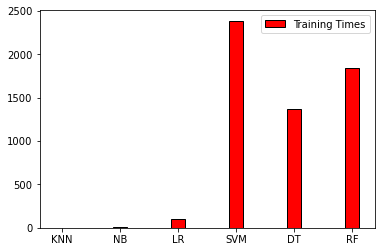

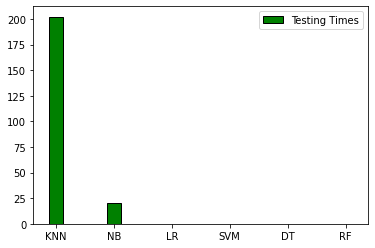

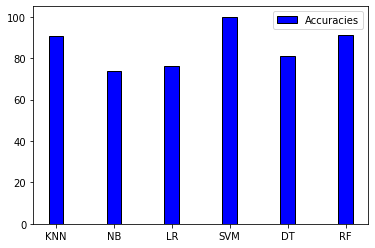

In [27]:
Training_times=[i[0] for i in data_dict.values()]
Testing_times=[i[1] for i in data_dict.values()]
Accuracies=[i[2] for i in data_dict.values()]
barwidth=0.25
br=np.arange(len(Training_times))
plt.figure()
plt.bar(br,Training_times,color="r",width=barwidth,edgecolor="k",label="Training Times")
plt.xticks([r for r in range(6)],data_dict.keys())
plt.legend()
plt.figure()
plt.bar(br,Testing_times,color="g",width=barwidth,edgecolor="k",label="Testing Times")
plt.xticks([r for r in range(6)],data_dict.keys())
plt.legend()
plt.figure()
plt.bar(br,Accuracies,color="b",width=barwidth,edgecolor="k",label="Accuracies")
plt.xticks([r for r in range(6)],data_dict.keys())
plt.legend()

# Implementation of the Algorithms using Sci-Kit learn Package

In [28]:
img_train_path="mnist_data/train-images-idx3-ubyte"
label_train_path="mnist_data/train-labels-idx1-ubyte"

img_test_path = "mnist_data/t10k-images-idx3-ubyte"
label_test_path = "mnist_data/t10k-labels-idx1-ubyte"

Images_train = idx2numpy.convert_from_file(img_train_path)
Labels_train = idx2numpy.convert_from_file(label_train_path)

Images_test = idx2numpy.convert_from_file(img_test_path)
Labels_test = idx2numpy.convert_from_file(label_test_path)

Images_train=Images_train.reshape((Images_train.shape[0],784))
Images_test=Images_test.reshape((Images_test.shape[0],784))

ma,mi=np.max(Images_train),np.min(Images_train)
Images_train=(Images_train-mi)/(ma-mi)
ma,mi=np.max(Images_test),np.min(Images_test)
Images_test=(Images_test-mi)/(ma-mi)

In [29]:
data_dict_skl={"KNN":[-1,-1,-1,None],"GNB":[-1,-1,-1,None],"MNB":[-1,-1,-1,None],"LR":[-1,-1,-1,None],"SVM":[-1,-1,-1,None],"DT":[-1,-1,-1,None],"RF":[-1,-1,-1,None]}
predictions=[[] for i in range(len(data_dict_skl))]

# KNN

In [30]:
K=35
start=time.time()
KNN=KNeighborsClassifier(n_neighbors=K)
KNN.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["KNN"][0]=t

Training time : 0.0h 0.0m 0.06431388854980469s


In [31]:
start=time.time()
KNN_pred=KNN.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
acc=(len(np.where(KNN_pred==Labels_test)[0])/len(KNN_pred))*100
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["KNN"][1]=t
print(f"Accuracy : {acc}%")
data_dict_skl["KNN"][2]=acc
data_dict_skl["KNN"][3]=KNN
predictions[0]=0
predictions[0]=KNN_pred

Testing time : 0.0h 0.0m 18.940880060195923s
Accuracy : 95.78%


# Naive Bayes

In [32]:
start=time.time()
NB=GaussianNB()
NB.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["GNB"][0]=t

Training time : 0.0h 0.0m 0.33493924140930176s


In [33]:
start=time.time()
NB_pred=NB.predict(Images_test)
end=time.time()
acc=(len(np.where(NB_pred==Labels_test)[0])/len(NB_pred))*100
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["GNB"][1]=t
print(f"Accuracy : {acc}%")
data_dict_skl["GNB"][2]=acc
data_dict_skl["GNB"][3]=NB
predictions[1]=NB_pred

Testing time : 0.0h 0.0m 0.1720130443572998s
Accuracy : 55.58%


In [34]:
start=time.time()
NB=MultinomialNB()
NB.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["MNB"][0]=t

Training time : 0.0h 0.0m 0.06583499908447266s


In [35]:
start=time.time()
NB_pred=NB.predict(Images_test)
end=time.time()
acc=(len(np.where(NB_pred==Labels_test)[0])/len(NB_pred))*100
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["MNB"][1]=t
print(f"Accuracy : {acc}%")
data_dict_skl["MNB"][2]=acc
data_dict_skl["MNB"][3]=NB
predictions[2]=NB_pred

Testing time : 0.0h 0.0m 0.0071048736572265625s
Accuracy : 83.57%


# Logistic Regression

In [36]:
start=time.time()
Lreg = LogisticRegression()
Lreg.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["LR"][0]=t

Training time : 0.0h 0.0m 6.109141111373901s


/Users/nikhilsaigorantla/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
start=time.time()
Lreg_pred=Lreg.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
acc=(len(np.where(Lreg_pred==Labels_test)[0])/len(Lreg_pred))*100
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["LR"][1]=t
print(f"Accuracy : {acc}%")
data_dict_skl["LR"][2]=acc
data_dict_skl["LR"][3]=Lreg
predictions[3]=Lreg_pred

Testing time : 0.0h 0.0m 0.007895946502685547s
Accuracy : 92.58%


# Support Vector Machines

In [38]:
start=time.time()
svm=LinearSVC()
svm.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["SVM"][0]=t

Training time : 0.0h 4.0m 36.47583293914795s


/Users/nikhilsaigorantla/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [39]:
start=time.time()
y_pred=svm.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["SVM"][1]=t
s=0
for i in range(len(Labels_test)):
    if y_pred[i]==Labels_test[i]:
        s+=1
acc=(s/len(Labels_test)*100)
print(f"Accuracy : {acc}%")
data_dict_skl["SVM"][2]=acc
data_dict_skl["SVM"][3]=svm
predictions[4]=y_pred

Testing time : 0.0h 0.0m 0.006512165069580078s
Accuracy : 91.82000000000001%


# Decision Tree

In [40]:
start=time.time()
dt=DecisionTreeClassifier()
dt.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["DT"][0]=t

Training time : 0.0h 0.0m 11.617966890335083s


In [41]:
start=time.time()
y_pred=dt.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["DT"][1]=t
s=0
for i in range(len(Labels_test)):
    if y_pred[i]==Labels_test[i]:
        s+=1
acc=(s/len(Labels_test)*100)
print(f"Accuracy : {acc}%")
data_dict_skl["DT"][2]=acc
data_dict_skl["DT"][3]=dt
predictions[5]=y_pred

Testing time : 0.0h 0.0m 0.014184951782226562s
Accuracy : 87.87%


# Random Forest

In [42]:
start=time.time()
rf=RandomForestClassifier()
rf.fit(Images_train,Labels_train)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Training time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["RF"][0]=t

Training time : 0.0h 1.0m 37.01309776306152s


In [43]:
start=time.time()
y_pred=rf.predict(Images_test)
end=time.time()
t=end-start if end-start>10**(-7) else 0
print(f"Testing time : {t//3600}h {t//60-(t//3600)*60}m {t-(t//60-(t//3600)*60)*60}s")
data_dict_skl["RF"][1]=t
s=0
for i in range(len(Labels_test)):
    if y_pred[i]==Labels_test[i]:
        s+=1
acc=(s/len(Labels_test)*100)
print(f"Accuracy : {acc}%")
data_dict_skl["RF"][2]=acc
data_dict_skl["RF"][3]=rf
predictions[6]=y_pred

Testing time : 0.0h 0.0m 0.19104623794555664s
Accuracy : 96.85000000000001%


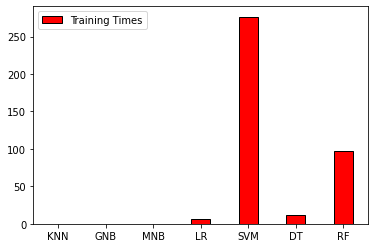

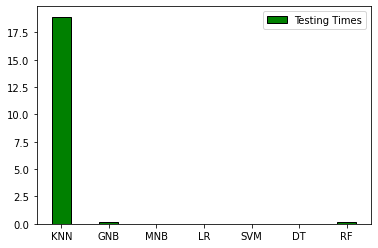

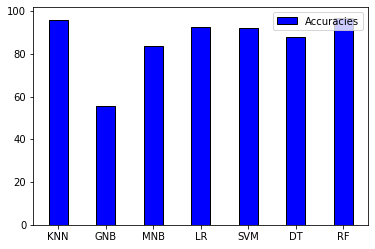

In [45]:
Training_times=([i[0] for i in data_dict_skl.values()])
Testing_times=([i[1] for i in data_dict_skl.values()])
Accuracies=[i[2] for i in data_dict_skl.values()]
barwidth=0.4
br=np.arange(len(Training_times))
plt.bar(br,Training_times,color="r",width=barwidth,edgecolor="k",label="Training Times")
plt.xticks([r for r in range(7)],data_dict_skl.keys())
plt.legend()
plt.figure()
plt.bar(br,Testing_times,color="g",width=barwidth,edgecolor="k",label="Testing Times")
plt.xticks([r for r in range(7)],data_dict_skl.keys())
plt.legend()
plt.figure()
plt.bar(br,Accuracies,color="b",width=barwidth,edgecolor="k",label="Accuracies")
plt.xticks([r for r in range(7)],data_dict_skl.keys())
plt.legend()

In [46]:
y=np.array(predictions)
y = y.T
print(y.shape)

(10000, 7)


In [47]:
Y_pred=np.array([max(i,key=list(i).count) for i in y])
print(Y_pred.shape)

(10000,)


In [48]:
s=0
for i in range(len(Labels_test)):
    if Y_pred[i]==Labels_test[i]:
        s+=1
acc=(s/len(Labels_test)*100)
print(f"Accuracy : {acc}%")

Accuracy : 95.15%


In [49]:
trained_models=[j[3] for j in data_dict_skl.values()]

[8, 5, 9, 8, 8, 7, 1]


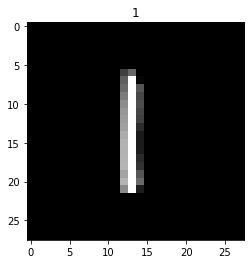

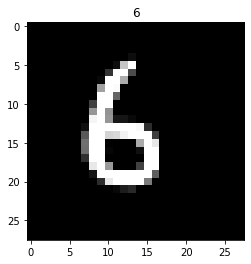

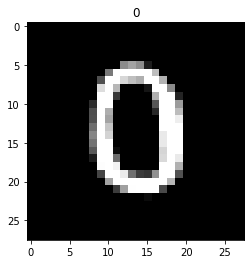

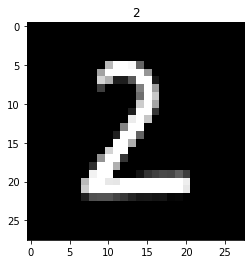

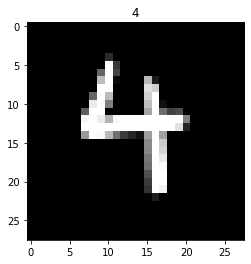

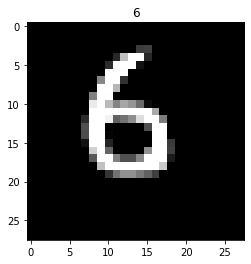

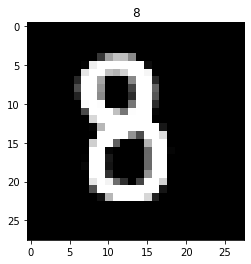

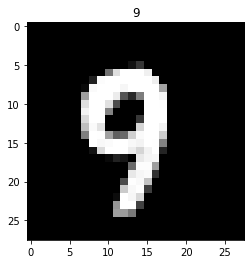

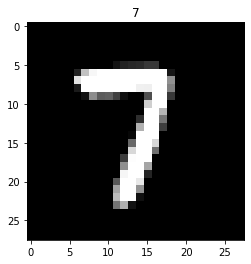

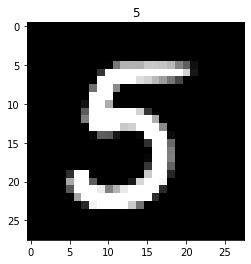

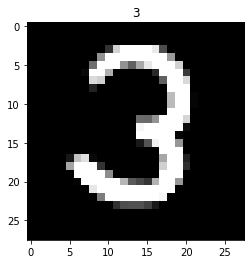

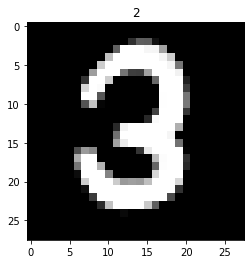

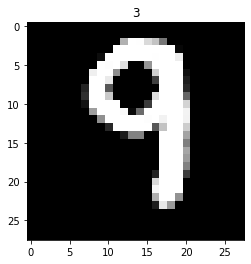

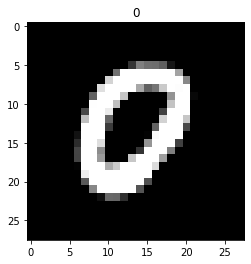

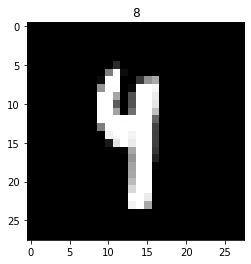

In [71]:
pred=[]
for i in range(16):
    img=cv.imread(f"test_images/digit_{str(i)}.png")[:,:,0]
    plt.figure()
    img=np.array(img).reshape(1,784)
    img=np.invert(img)
    plt.imshow(img.reshape(28,28),cmap="gray")
    p=[]
    for j in trained_models:
        p.append(*j.predict(img))
    pred.append(max(p,key=p.count))
    plt.title(str(pred[-1]))
print(p)